In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc, roc_auc_score

 ----------------------------------------------
 **Exploring models**
-
 ----------------------------------------------

In [3]:
# Remove identifiers and non-feature columns. Right now only worrying about VOCs, not demographics yet.
df_main = pd.read_csv("df_main_normalized.csv")

y = df_main["TB Status"]  # Target
X = df_main.drop(columns=["PID", "TB Status", "Age", "BMI", "HIV Status"])  # Features without demographics for now

In [4]:
# QC Checks
print(np.isnan(X).sum().sum())
print(np.isinf(X).sum().sum())
# print(X.describe())
print((X.std() == 0).sum())  # Number of zero-variance features

0
0
0


Above sets up the data and removes the target from the features.

The next cell below is to figure out what number of features is appropriate for SVM-RFE.

In [5]:
# I trust my model and the ROC-AUC is stable so I'm going to supress some warnings for a cleaner output
import warnings
warnings.filterwarnings("ignore", message=".*invalid value encountered in matmul.*")
warnings.filterwarnings("ignore", message=".*divide by zero encountered in matmul.*")
warnings.filterwarnings("ignore", message=".*overflow encountered in matmul.*")

****SVM-RFE SECTION****

5 features → ROC-AUC: 0.830
10 features → ROC-AUC: 0.834
15 features → ROC-AUC: 0.793
20 features → ROC-AUC: 0.766
25 features → ROC-AUC: 0.762
30 features → ROC-AUC: 0.740
35 features → ROC-AUC: 0.719
40 features → ROC-AUC: 0.734


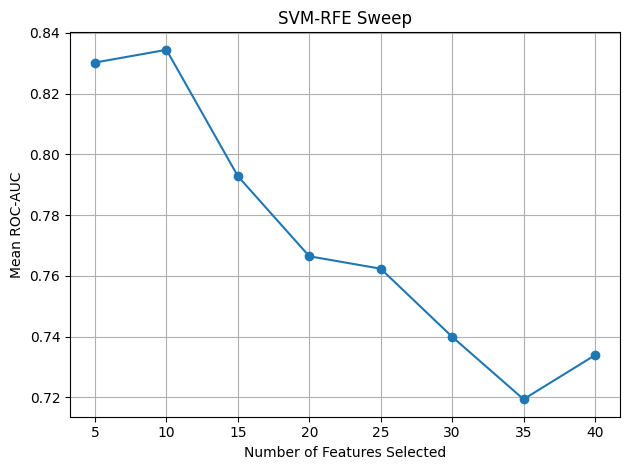

In [6]:
# Config
svc = LinearSVC(C=1, max_iter=10000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_counts = list(range(5, min(41, X.shape[1]), 5))
scores = []

# Sweep
for n in feature_counts:
    pipeline = Pipeline([
        ("feature_selection", RFE(estimator=svc, n_features_to_select=n)),
        ("classifier", svc)
    ])
    score = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc').mean()
    scores.append(score)
    print(f"{n} features → ROC-AUC: {score:.3f}")

plt.plot(feature_counts, scores, marker='o')
plt.xlabel("Number of Features Selected")
plt.ylabel("Mean ROC-AUC")
plt.title("SVM-RFE Sweep")
plt.grid(True)
plt.tight_layout()
plt.show()

**Note to Self** I'm getting a ton of runtime warnings related to divide by zero encoutered. I'm guessing this is due to zero variance in some columns maybe? Everything normalized well so I dont think it's a skew issue. Going to try to run a variance filter.

Tried the variance filter. it didn't drop anything so these errors are something else...



Based off of the ROC-AUC, we are selecting 5 features. 10 does show better mean ROC, but looking for a simpler model


SVM-RFE: ROC-AUC vs. C Sweep (5 features)
C=0.001  → Mean ROC-AUC: 0.8339
C=0.01   → Mean ROC-AUC: 0.8334
C=0.1    → Mean ROC-AUC: 0.8438
C=1      → Mean ROC-AUC: 0.8302
C=10     → Mean ROC-AUC: 0.8122


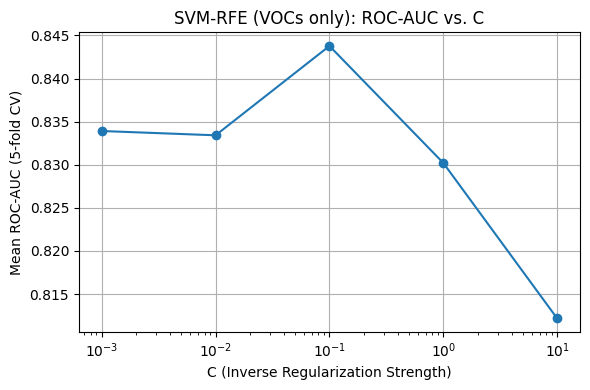

In [7]:
voc_columns = [col for col in df_main.columns if col not in ["PID", "TB Status", "Age", "BMI", "HIV Status"]]
X_voc = df_main[voc_columns]
y_voc = df_main["TB Status"]

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Sweep C values (strong to weak regularization)
C_values = [0.001, 0.01, 0.1, 1, 10]
svm_auc_scores = []

# Choose fixed number of features for fair comparison (e.g., 5 based on earlier RFE)
n_features = 5

print("\nSVM-RFE: ROC-AUC vs. C Sweep (5 features)")

for C in C_values:
    svc = LinearSVC(C=C, max_iter=10000)
    pipeline = Pipeline([
        ("feature_selection", RFE(estimator=svc, n_features_to_select=n_features)),
        ("classifier", svc)
    ])
    score = cross_val_score(pipeline, X_voc, y_voc, cv=cv, scoring='roc_auc').mean()
    svm_auc_scores.append(score)
    print(f"C={C:<6} → Mean ROC-AUC: {score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(C_values, svm_auc_scores, marker='o')
plt.xscale("log")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("Mean ROC-AUC (5-fold CV)")
plt.title("SVM-RFE (VOCs only): ROC-AUC vs. C")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Based on the above graph
C_for_SVM = 0.1

In [9]:
svm = svc = LinearSVC(C=C_for_SVM, max_iter=10000)

# select top 5
rfe = RFE(estimator=svm, n_features_to_select=5, step=1)

# Fit RFE model
rfe.fit(X, y)

RFE(estimator=LinearSVC(C=0.1, max_iter=10000), n_features_to_select=5)

In [10]:
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features.tolist())

# Rankings (1 = selected)
ranking = pd.Series(rfe.ranking_, index=X.columns).sort_values()
print("Top 20 ranked features:")
print(ranking.head(20))

Selected features: ['000098-86-2_group2', '000149-57-5_group1', '001762-27-2_group1', '019549-87-2_group1', '063521-76-6_group3']
Top 20 ranked features:
063521-76-6_group3      1
001762-27-2_group1      1
000098-86-2_group2      1
019549-87-2_group1      1
000149-57-5_group1      1
1000401-12-0_group1     2
054446-78-5_group1      3
000095-16-9_group2      4
000115-11-7_group2      5
000100-41-4_group4      6
001074-43-7_group1      7
000617-94-7_group1      8
000100-42-5_group1      9
001122-82-3_group1     10
000108-87-2_group2     11
000110-98-5_group1     12
000067-64-1_group2     13
000104-76-7_group1     14
000110-88-3_group1     15
1000132-10-9_group2    16
dtype: int64


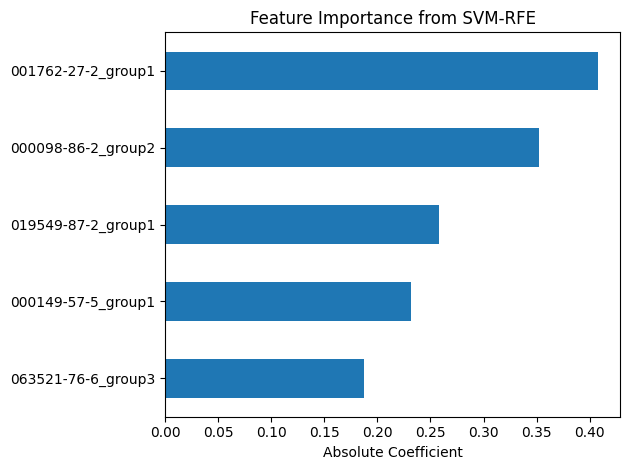

In [11]:
# Visualizing
# Refit SVM just on selected features for coefficient extraction
svm.fit(X[selected_features], y)
coefs = pd.Series(np.abs(svm.coef_[0]), index=selected_features)

# Plot
coefs.sort_values().plot(kind='barh')
plt.title("Feature Importance from SVM-RFE")
plt.xlabel("Absolute Coefficient")
plt.tight_layout()
plt.show()

In [12]:
# Cross-validate
# Needing this LinearSVC and not just linear. The data is fine but it's breaking. Probably too many features for low number of samples?
# LinearSVC has a better solver for higher dimensions.
pipeline = Pipeline([
    ("feature_selection", RFE(LinearSVC(C=C_for_SVM, max_iter=10000), n_features_to_select=5)),
    ("svm", LinearSVC(C=1, max_iter=10000))
])

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds seems standard by literature. Random state of 42 similar to above.
scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc")

print(f"Mean ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")

Mean ROC-AUC: 0.8425 ± 0.0470


****LASSO****

In [13]:
# LASSO with l1
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.10, max_iter=10000)  # A lower C means fewer features (0.5, 0.1)

# CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('lasso', lasso)
])

scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
print(f"Mean ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")

Mean ROC-AUC: 0.8730 ± 0.0248


**NOTE** These errors are the same reason as with SVM-RFE, that the dim of the data is very high while the n_sample count isn't super large as well.


LASSO-selected features with odds ratios:
                     Log-Odds Coef  Odds Ratio
000095-16-9_group2        0.167348    1.182166
000115-11-7_group2        0.154405    1.166963
000100-41-4_group4        0.068302    1.070688
000108-94-1_group1        0.018918    1.019098
001640-89-7_group2        0.007391    1.007418
1000132-10-9_group2      -0.038263    0.962460
000103-65-1_group1       -0.043613    0.957325
000620-14-4_group1       -0.049169    0.952020
001074-43-7_group1       -0.072062    0.930474
000124-19-6_group1       -0.077172    0.925730
001122-82-3_group1       -0.084239    0.919212
054446-78-5_group1       -0.093408    0.910822
000098-86-2_group2       -0.121154    0.885898
000109-52-4_group1       -0.163533    0.849139
1000401-12-0_group1      -0.174101    0.840212
063521-76-6_group3       -0.179975    0.835291
019549-87-2_group1       -0.274590    0.759884
001762-27-2_group1       -0.747737    0.473437


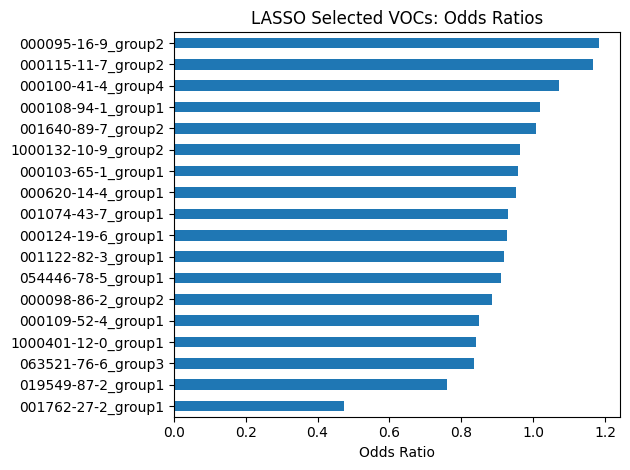

In [14]:
# Fit on full dataset
lasso.fit(X, y)

# coef and odds ratios
coefs = pd.Series(lasso.coef_[0], index=X.columns)
nonzero_coefs = coefs[coefs != 0]
odds_ratios = np.exp(nonzero_coefs)

# Combine into a df for report
summary_df = pd.DataFrame({
    "Log-Odds Coef": nonzero_coefs,
    "Odds Ratio": odds_ratios
}).sort_values("Odds Ratio", ascending=False)

print("\nLASSO-selected features with odds ratios:")
print(summary_df)

# visualize odds ratios
summary_df["Odds Ratio"].sort_values().plot(kind='barh')
plt.title("LASSO Selected VOCs: Odds Ratios")
plt.xlabel("Odds Ratio")
plt.tight_layout()
plt.show()

Was there overlap with LASSO's selection and SVM-RFE?
YES!

This similiarity makes sense, as these are, ideally, impactful predictors.

****LASSO Based On SVM-RFE Features****

Mean ROC-AUC (LASSO on SVM-RFE): 0.8905 ± 0.0383

LASSO-on-RFE selected features with odds ratios:
                    Log-Odds Coef  Odds Ratio
063521-76-6_group3      -0.197698    0.820618
000098-86-2_group2      -0.340807    0.711196
019549-87-2_group1      -0.352368    0.703021
001762-27-2_group1      -0.933308    0.393251


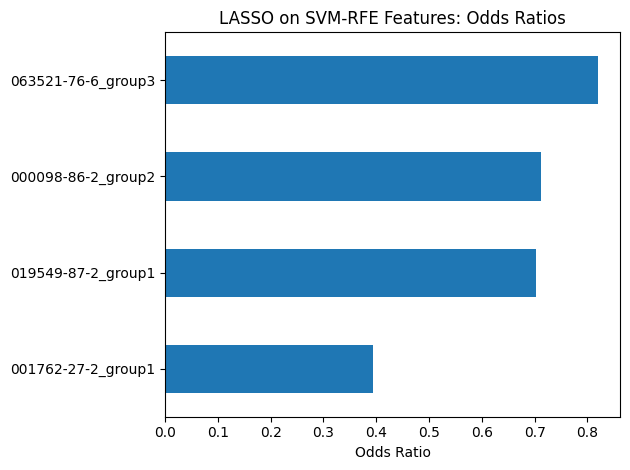

In [15]:
# SVM-RFE selected features:

selected_features = [
    "063521-76-6_group3",
    "001762-27-2_group1",
    "000098-86-2_group2",
    "019549-87-2_group1",
    "000149-57-5_group1"
]

X_sub = df_main[selected_features]
y = df_main["TB Status"]  # this hasn't changed

lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)  # same penalty as previous LASSO

# CV performance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lasso, X_sub, y, cv=cv, scoring="roc_auc")
print(f"Mean ROC-AUC (LASSO on SVM-RFE): {scores.mean():.4f} ± {scores.std():.4f}")

# Fit final model
lasso.fit(X_sub, y)

# coefficients and odds ratios
coefs = pd.Series(lasso.coef_[0], index=X_sub.columns)
nonzero_coefs = coefs[coefs != 0]
odds_ratios = np.exp(nonzero_coefs)

# report
summary_df = pd.DataFrame({
    "Log-Odds Coef": nonzero_coefs,
    "Odds Ratio": odds_ratios
}).sort_values("Odds Ratio", ascending=False)

print("\nLASSO-on-RFE selected features with odds ratios:")
print(summary_df)

# Visualize
summary_df["Odds Ratio"].sort_values().plot(kind='barh')
plt.title("LASSO on SVM-RFE Features: Odds Ratios")
plt.xlabel("Odds Ratio")
plt.tight_layout()
plt.show()

----------------------------------------------

**Testing models post exploration**
-

 ----------------------------------------------

In [16]:
x_all_no_demo = df_main.drop(columns=["PID", "TB Status", "Age", "BMI", "HIV Status"])
y_all_no_demo = df_main["TB Status"]

# 80/20 spilt
x_train_no_demo, x_test_no_demo, y_train_no_demo, y_test_no_demo = train_test_split(
    x_all_no_demo, y_all_no_demo, test_size=0.2, stratify=y_all_no_demo, random_state=42
)

print(f"Train size: {x_train_no_demo.shape[0]}, Test size: {x_test_no_demo.shape[0]}")

Train size: 185, Test size: 47


In [17]:
# Fit RFE to training data
svm = LinearSVC(C=C_for_SVM, max_iter=10000)
rfe = RFE(estimator=svm, n_features_to_select=5)
rfe.fit(x_train_no_demo, y_train_no_demo)

# Get VOCs
svm_rfe_features = x_train_no_demo.columns[rfe.support_].tolist()
svm_rfe_features_no_demos = svm_rfe_features  # this one line is for later comparison
print("SVM-RFE selected features:", svm_rfe_features)

# Training model on selected VOCs
svm_final_no_demo = LinearSVC(C=C_for_SVM, max_iter=10000)
svm_final_no_demo.fit(x_train_no_demo[svm_rfe_features], y_train_no_demo)

SVM-RFE selected features: ['000109-52-4_group1', '000115-11-7_group2', '001762-27-2_group1', '019549-87-2_group1', '1000132-10-9_group2']


LinearSVC(C=0.1, max_iter=10000)

Note: Selected features differ from exploratory run

In [18]:
# LASSO
lasso_full = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_full.fit(x_train_no_demo, y_train_no_demo)

# Get non-zero VOCs
coefs_full = pd.Series(lasso_full.coef_[0], index=x_train_no_demo.columns)
lasso_full_features = coefs_full[coefs_full != 0].index.tolist()
lasso_full_features_no_demos = lasso_full_features  # this one line is for later comparisons
print("LASSO (Full) selected features:", lasso_full_features)

# Refit model using only those features
lasso_final_no_demo = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_final_no_demo.fit(x_train_no_demo[lasso_full_features], y_train_no_demo)

LASSO (Full) selected features: ['000095-16-9_group2', '000100-41-4_group4', '000109-52-4_group1', '000110-88-3_group1', '000115-11-7_group2', '000124-19-6_group1', '000620-14-4_group1', '001074-43-7_group1', '001762-27-2_group1', '019549-87-2_group1', '063521-76-6_group3', '1000132-10-9_group2', '1000401-12-0_group1']


LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='liblinear')

In [19]:
# LASSO on SVM-RFE
# ID VOC feature overlap
overlap_features = list(set(svm_rfe_features_no_demos) & set(lasso_full_features_no_demos))
print("Overlap features used in LASSO-on-RFE:", overlap_features)

Overlap features used in LASSO-on-RFE: ['019549-87-2_group1', '000109-52-4_group1', '000115-11-7_group2', '001762-27-2_group1', '1000132-10-9_group2']


In [20]:
# Train LASSO
lasso_on_rfe_no_demo = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_on_rfe_no_demo.fit(x_train_no_demo[overlap_features], y_train_no_demo)

LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='liblinear')

**Running models on Test Sets**

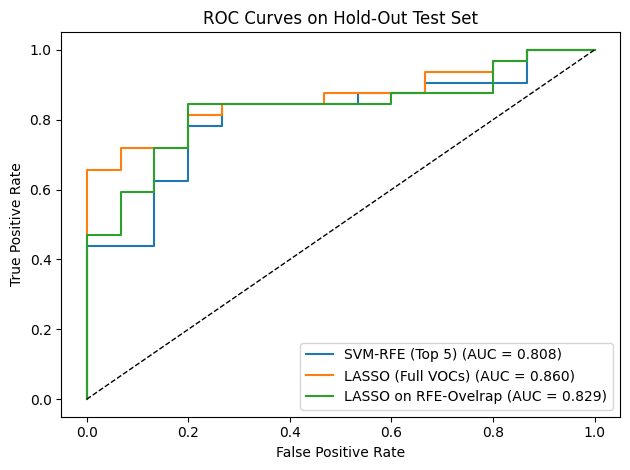


Final ROC-AUCs on Test Set:
SVM-RFE (Top 5): 0.808
LASSO (Full VOCs): 0.860
LASSO on Overlap: 0.829


In [21]:
def plot_model_roc(model, x_test, y_test, label):
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(x_test)[:, 1]
    else:
        probs = model.decision_function(x_test)
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})')
    return roc_auc


# Plot all
plt.figure()


auc_svm = plot_model_roc(svm_final_no_demo, x_test_no_demo[svm_rfe_features], y_test_no_demo, "SVM-RFE (Top 5)")
auc_lasso_full = plot_model_roc(lasso_final_no_demo, x_test_no_demo[lasso_full_features], y_test_no_demo, "LASSO (Full VOCs)")
auc_lasso_overlap = plot_model_roc(lasso_on_rfe_no_demo, x_test_no_demo[overlap_features], y_test_no_demo, "LASSO on RFE-Ovelrap")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Hold-Out Test Set")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print("\nFinal ROC-AUCs on Test Set:")
print(f"SVM-RFE (Top 5): {auc_svm:.3f}")
print(f"LASSO (Full VOCs): {auc_lasso_full:.3f}")
print(f"LASSO on Overlap: {auc_lasso_overlap:.3f}")

In [22]:
coefs = pd.Series(lasso_on_rfe_no_demo.coef_[0], index=overlap_features)
odds_ratios = np.exp(coefs)
print(pd.DataFrame({'Log-Odds': coefs, 'Odds Ratio': odds_ratios}))

                     Log-Odds  Odds Ratio
019549-87-2_group1  -0.349632    0.704947
000109-52-4_group1  -0.417625    0.658609
000115-11-7_group2   0.138728    1.148812
001762-27-2_group1  -0.783395    0.456853
1000132-10-9_group2 -0.211304    0.809528


 ----------------------------------------------

**Adding in Demographics**
-

 ----------------------------------------------

In [23]:
# Reload full dataset with Demos now
df_main = pd.read_csv("df_main_normalized.csv")

# Check for missing demos. should be -1 if unknown
print(df_main[["Age", "BMI", "HIV Status"]].isnull().sum())
print(f"Count of -1 in 'Age': {(df_main['Age'] == -1).sum()}")
print(f"Count of -1 in 'BMI': {(df_main['BMI'] == -1).sum()}")
print(f"Count of -1 in 'HIV Status': {(df_main['HIV Status'] == -1).sum()}")

Age           0
BMI           0
HIV Status    0
dtype: int64
Count of -1 in 'Age': 0
Count of -1 in 'BMI': 2
Count of -1 in 'HIV Status': 9


This shows that we are missing:
* 2 BMI values
* 9 HIV statuses

In [24]:
# Drop rows where Age, BMI, or HIV Status is -1 (placeholder for missing)
df_main_clean = df_main[
    (df_main["Age"] != -1) &
    (df_main["BMI"] != -1) &
    (df_main["HIV Status"] != -1)
].copy()

print(f"Rows dropped: {df_main.shape[0] - df_main_clean.shape[0]}")

Rows dropped: 9


In [25]:
# Define features and outcome
x_all_demo = df_main_clean.drop(columns=["PID", "TB Status"])
y_all_demo = df_main_clean["TB Status"]

# Train-test split
x_train_demo, x_test_demo, y_train_demo, y_test_demo = train_test_split(
    x_all_demo, y_all_demo, test_size=0.2, stratify=y_all_demo, random_state=42
)

In [26]:
# SVM-RFE on all VOCs + demographics
svm = LinearSVC(C=C_for_SVM, max_iter=10000)
rfe = RFE(estimator=svm, n_features_to_select=5)
rfe.fit(x_train_demo, y_train_demo)

svm_rfe_features_with_demo = x_train_demo.columns[rfe.support_].tolist()
print("SVM-RFE with demographics selected features:", svm_rfe_features_with_demo)

# Final model
svm_final_demo = LinearSVC(C=C_for_SVM, max_iter=10000)
svm_final_demo.fit(x_train_demo[svm_rfe_features_with_demo], y_train_demo)

SVM-RFE with demographics selected features: ['000109-52-4_group1', '001762-27-2_group1', '019549-87-2_group1', '063521-76-6_group3', '1000401-12-0_group1']


LinearSVC(C=0.1, max_iter=10000)

Note:

this tells us that the 5 VOCs are still more predictive than demographics.

This does not tell us still if BMI/Age/HIV status influences VOCs though.

In [27]:
# fit LASSO on full plus demos
lasso_full = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_full.fit(x_train_demo, y_train_demo)

# selected features
coefs_full = pd.Series(lasso_full.coef_[0], index=x_train_demo.columns)
nonzero_full = coefs_full[coefs_full != 0]
lasso_features_demo = nonzero_full.index.tolist()  # Ensures consistent column order
lasso_full_features_with_demos = nonzero_full.index.tolist()  # this line is for a later comparison
odds_ratios_full = np.exp(nonzero_full)


summary_lasso_full = pd.DataFrame({
    "Log-Odds": nonzero_full,
    "Odds Ratio": odds_ratios_full
}).sort_values("Odds Ratio", ascending=False)

print("LASSO (Full + Demographics) selected features with odds ratios:")
print(summary_lasso_full)

# refit and evaluate with the test set
lasso_final_demo = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_final_demo.fit(x_train_demo[lasso_features_demo], y_train_demo)

probs_lasso_full_demo = lasso_final_demo.predict_proba(x_test_demo[lasso_features_demo])[:, 1]
auc_lasso_full_demo = roc_auc_score(y_test_demo, probs_lasso_full_demo)
print(f"LASSO (Full + Demos) ROC-AUC on test set: {auc_lasso_full:.4f}")

LASSO (Full + Demographics) selected features with odds ratios:
                     Log-Odds  Odds Ratio
000115-11-7_group2   0.177429    1.194144
000095-16-9_group2   0.072129    1.074794
BMI                  0.026319    1.026668
Age                  0.003442    1.003448
001074-43-7_group1  -0.008838    0.991201
000098-86-2_group2  -0.046872    0.954209
1000132-10-9_group2 -0.127425    0.880360
1000401-12-0_group1 -0.168926    0.844571
063521-76-6_group3  -0.187889    0.828707
000620-14-4_group1  -0.214204    0.807184
019549-87-2_group1  -0.298353    0.742040
000109-52-4_group1  -0.299941    0.740862
001762-27-2_group1  -0.682025    0.505592
LASSO (Full + Demos) ROC-AUC on test set: 0.8604


In [28]:
# LASSO on SVM-RFE ID'd features

# SVM-RFE VOCs
svm_rfe_vocs_demo = svm_rfe_features_with_demo.copy()  # the 5 VOCs from earlier RFE

# add demos
demo_vars = ["Age", "BMI", "HIV Status"]
for var in demo_vars:
    if var not in svm_rfe_vocs_demo:
        svm_rfe_vocs_demo.append(var)

print("Features used in LASSO-on-RFE + Demographics:", svm_rfe_vocs_demo)

# LASSO on training data
lasso_on_rfe_demo = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_on_rfe_demo.fit(x_train_demo[svm_rfe_vocs_demo], y_train_demo)

# Features and ORs
coefs_rfe_demo = pd.Series(lasso_on_rfe_demo.coef_[0], index=svm_rfe_vocs_demo)
nonzero_rfe_demo = coefs_rfe_demo[coefs_rfe_demo != 0]
odds_ratios_rfe_demo = np.exp(nonzero_rfe_demo)

summary_rfe_demo = pd.DataFrame({
    "Log-Odds": nonzero_rfe_demo,
    "Odds Ratio": odds_ratios_rfe_demo
}).sort_values("Odds Ratio", ascending=False)

print("\nLASSO (SVM-RFE + Demos) selected features with odds ratios:")
print(summary_rfe_demo)

# Test set
probs_rfe_demo = lasso_on_rfe_demo.predict_proba(x_test_demo[svm_rfe_vocs_demo])[:, 1]
auc_rfe_demo = roc_auc_score(y_test_demo, probs_rfe_demo)
print(f"LASSO on SVM-RFE VOCs + Demos ROC-AUC on test set: {auc_rfe_demo:.4f}")

Features used in LASSO-on-RFE + Demographics: ['000109-52-4_group1', '001762-27-2_group1', '019549-87-2_group1', '063521-76-6_group3', '1000401-12-0_group1', 'Age', 'BMI', 'HIV Status']

LASSO (SVM-RFE + Demos) selected features with odds ratios:
                     Log-Odds  Odds Ratio
BMI                  0.026771    1.027132
Age                  0.002420    1.002422
1000401-12-0_group1 -0.241324    0.785587
063521-76-6_group3  -0.279609    0.756079
019549-87-2_group1  -0.300307    0.740591
000109-52-4_group1  -0.415829    0.659793
001762-27-2_group1  -0.694359    0.499395
LASSO on SVM-RFE VOCs + Demos ROC-AUC on test set: 0.8667


In [29]:
# LASSO on SVM-RFE ID'd features WITHOUT added DEMOS

# SVM-RFE VOCs
svm_rfe_vocs_demo = svm_rfe_features_with_demo.copy()  # the 5 VOCs from earlier RFE

print("Features used in LASSO-on-RFE + Demographics:", svm_rfe_vocs_demo)

# LASSO on training data
lasso_on_rfe_demo = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_on_rfe_demo.fit(x_train_demo[svm_rfe_vocs_demo], y_train_demo)

# Features and ORs
coefs_rfe_demo = pd.Series(lasso_on_rfe_demo.coef_[0], index=svm_rfe_vocs_demo)
nonzero_rfe_demo = coefs_rfe_demo[coefs_rfe_demo != 0]
odds_ratios_rfe_demo = np.exp(nonzero_rfe_demo)

summary_rfe_demo = pd.DataFrame({
    "Log-Odds": nonzero_rfe_demo,
    "Odds Ratio": odds_ratios_rfe_demo
}).sort_values("Odds Ratio", ascending=False)

print("\nLASSO (SVM-RFE + Demos) selected features with odds ratios:")
print(summary_rfe_demo)

# Test set
probs_rfe_demo = lasso_on_rfe_demo.predict_proba(x_test_demo[svm_rfe_vocs_demo])[:, 1]
auc_rfe_demo = roc_auc_score(y_test_demo, probs_rfe_demo)
print(f"LASSO on SVM-RFE VOCs + Demos ROC-AUC on test set: {auc_rfe_demo:.4f}")

Features used in LASSO-on-RFE + Demographics: ['000109-52-4_group1', '001762-27-2_group1', '019549-87-2_group1', '063521-76-6_group3', '1000401-12-0_group1']

LASSO (SVM-RFE + Demos) selected features with odds ratios:
                     Log-Odds  Odds Ratio
1000401-12-0_group1 -0.202254    0.816887
063521-76-6_group3  -0.248105    0.780278
019549-87-2_group1  -0.285973    0.751283
000109-52-4_group1  -0.378525    0.684871
001762-27-2_group1  -0.694218    0.499465
LASSO on SVM-RFE VOCs + Demos ROC-AUC on test set: 0.8844


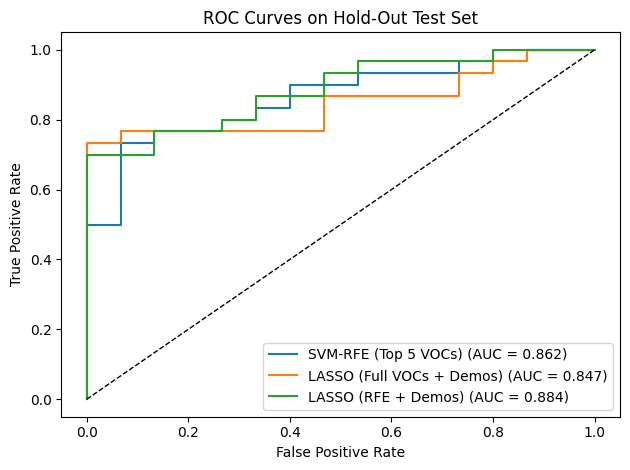


Final ROC-AUCs on Test Set:
SVM-RFE (Top 5 VOCs): 0.862
LASSO (Full VOCs + Demos): 0.847
LASSO (RFE + Demos): 0.884


In [31]:
# same fxn as earlier but putting in this block for quicker testing
from sklearn.metrics import auc
def plot_model_roc(model, x_test, y_test, label, linestyle='-', color=None):
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(x_test)[:, 1]
    else:
        probs = model.decision_function(x_test)
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})', linestyle=linestyle, color=color)
    return roc_auc


plt.figure()

auc_svm = plot_model_roc(svm_final_demo, x_test_demo[svm_rfe_features_with_demo], y_test_demo, "SVM-RFE (Top 5 VOCs)")
auc_lasso_full = plot_model_roc(lasso_final_demo, x_test_demo[lasso_features_demo], y_test_demo, "LASSO (Full VOCs + Demos)")
auc_lasso_rfe_demo = plot_model_roc(lasso_on_rfe_demo, x_test_demo[svm_rfe_vocs_demo], y_test_demo, "LASSO (RFE + Demos)")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Hold-Out Test Set")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


print("\nFinal ROC-AUCs on Test Set:")
print(f"SVM-RFE (Top 5 VOCs): {auc_svm:.3f}")
print(f"LASSO (Full VOCs + Demos): {auc_lasso_full:.3f}")
print(f"LASSO (RFE + Demos): {auc_lasso_rfe_demo:.3f}")

 ----------------------------------------------

**Looking at influence of demographics**
-

 ----------------------------------------------

At this point, the LASSO on the full data model was the most robust, but also not the most parsimonious. Yet, in order to test if demographics are playing a role, as these models select the most features, I'll be using these

In [32]:
# SVM (more focused on LASSO due to higher ROC-AUC values, but want to see this still)

# Convert to sets
svm_rfe_set_no_demos = set(svm_rfe_features_no_demos)
svm_rfe_set_with_demos = set(svm_rfe_features_with_demo)

# Compare
overlap = svm_rfe_set_no_demos & svm_rfe_set_with_demos
dropped = svm_rfe_set_no_demos - svm_rfe_set_with_demos
added = svm_rfe_set_with_demos - svm_rfe_set_no_demos

# Output
print(f"Shared features in both SVM models ({len(overlap)}):")
print(sorted(overlap))

print(f"\nDropped features SVM (in no-demo model, but not in demo model) ({len(dropped)}):")
print(sorted(dropped))

print(f"\nAdded features SVM (only selected when demos were included) ({len(added)}):")
print(sorted(added))

# LASSO:

# Convert to sets
lasso_set_no_demos = set(lasso_full_features_no_demos)
lasso_set_with_demos = set(lasso_full_features_with_demos)

# Compare
overlap = lasso_set_no_demos & lasso_set_with_demos
dropped = lasso_set_no_demos - lasso_set_with_demos
added = lasso_set_with_demos - lasso_set_no_demos

# Output
print(f"Shared features in both LASSO models ({len(overlap)}):")
print(sorted(overlap))

print(f"\nDropped features LASSO (in no-demo model, but not in demo model) ({len(dropped)}):")
print(sorted(dropped))

print(f"\nAdded features LASSO (only selected when demos were included) ({len(added)}):")
print(sorted(added))

Shared features in both SVM models (3):
['000109-52-4_group1', '001762-27-2_group1', '019549-87-2_group1']

Dropped features SVM (in no-demo model, but not in demo model) (2):
['000115-11-7_group2', '1000132-10-9_group2']

Added features SVM (only selected when demos were included) (2):
['063521-76-6_group3', '1000401-12-0_group1']
Shared features in both LASSO models (10):
['000095-16-9_group2', '000109-52-4_group1', '000115-11-7_group2', '000620-14-4_group1', '001074-43-7_group1', '001762-27-2_group1', '019549-87-2_group1', '063521-76-6_group3', '1000132-10-9_group2', '1000401-12-0_group1']

Dropped features LASSO (in no-demo model, but not in demo model) (3):
['000100-41-4_group4', '000110-88-3_group1', '000124-19-6_group1']

Added features LASSO (only selected when demos were included) (3):
['000098-86-2_group2', 'Age', 'BMI']


**SVM**

minor changes

**LASSO**

There were changes. Were any of these dropped VOCs correlated with BMI? using pearson

In [33]:
# VOC-BMI correlations
voc_columns = [col for col in df_main_clean.columns if col not in ["PID", "TB Status", "Age", "BMI", "HIV Status"]]
correlations = df_main_clean[voc_columns].corrwith(df_main_clean["BMI"])

# List of VOCs dropped when demographics were included
changed_VOCs = [
    '000100-41-4_group4',
    '000110-88-3_group1',
    '000124-19-6_group1',
    '000098-86-2_group2'
]

# Check each one's correlation with BMI
print("Dropped VOCs and their correlation with BMI:")
for voc in changed_VOCs:
    if voc in correlations:
        corr = correlations[voc]
        print(f"{voc:25} -> correlation with BMI: {corr:.3f}")
    else:
        print(f"{voc:25} -> not found in data")

Dropped VOCs and their correlation with BMI:
000100-41-4_group4        -> correlation with BMI: -0.082
000110-88-3_group1        -> correlation with BMI: 0.086
000124-19-6_group1        -> correlation with BMI: 0.071
000098-86-2_group2        -> correlation with BMI: 0.098


In general: The VOCs dropped from the LASSO model after adding demographics are not strongly correlated with BMI, suggesting they were excluded due to interactions with other selected features or shifts in model penalty allocation, instead of directly overlapping with BMI’s signal.

In [34]:
# doing the same above, but with age instead of BMI

# Correlate each VOC with Age
correlations_age = df_main_clean[voc_columns].corrwith(df_main_clean["Age"])

# Check age correlation for VOCs dropped when demographics were added
print("Dropped VOCs and their correlation with Age:")
for voc in changed_VOCs:
    if voc in correlations_age:
        corr = correlations_age[voc]
        print(f"{voc:25} -> correlation with Age: {corr:.3f}")
    else:
        print(f"{voc:25} -> not found in data")

Dropped VOCs and their correlation with Age:
000100-41-4_group4        -> correlation with Age: -0.076
000110-88-3_group1        -> correlation with Age: -0.004
000124-19-6_group1        -> correlation with Age: 0.008
000098-86-2_group2        -> correlation with Age: 0.061


With the five VOCs dropped from the LASSO model when demographic variables were included, none of them demonstrated moderate correlation.

In [35]:
# doing the same above, but with HIV status
# point-biserial correlation for dichotomous data

# VOC with HIV
correlations_hiv = df_main_clean[voc_columns].corrwith(df_main_clean["HIV Status"])

# Check correlation for dropped VOCs
print("Dropped VOCs and their correlation with HIV Status:")
for voc in changed_VOCs:
    if voc in correlations_hiv:
        corr = correlations_hiv[voc]
        print(f"{voc:25} -> correlation with HIV Status: {corr:.3f}")
    else:
        print(f"{voc:25} -> not found in data")

Dropped VOCs and their correlation with HIV Status:
000100-41-4_group4        -> correlation with HIV Status: 0.037
000110-88-3_group1        -> correlation with HIV Status: 0.004
000124-19-6_group1        -> correlation with HIV Status: 0.010
000098-86-2_group2        -> correlation with HIV Status: 0.002


Again, HIV status doesn't play a ton into this

 ----------------------------------------------

**Summarizing**
-

 ----------------------------------------------

In [36]:
# Recalculate correlations
voc_columns = [col for col in df_main_clean.columns if col not in ["PID", "TB Status", "Age", "BMI", "HIV Status"]]

corr_bmi = df_main_clean[voc_columns].corrwith(df_main_clean["BMI"])
corr_age = df_main_clean[voc_columns].corrwith(df_main_clean["Age"])
corr_hiv = df_main_clean[voc_columns].corrwith(df_main_clean["HIV Status"])

# Collect correlations into a DataFrame
summary_data = []
for voc in changed_VOCs:
    bmi_corr = corr_bmi.get(voc, float("nan"))
    age_corr = corr_age.get(voc, float("nan"))
    hiv_corr = corr_hiv.get(voc, float("nan"))

    if abs(bmi_corr) >= 0.15 or abs(age_corr) >= 0.15 or abs(hiv_corr) >= 0.15:
        likely = "Possibly"
    else:
        likely = "Unlikely"

    summary_data.append({
        "VOC": voc,
        "Corr with BMI": round(bmi_corr, 3),
        "Corr with Age": round(age_corr, 3),
        "Corr with HIV": round(hiv_corr, 3),
        "Likely Influenced": likely
    })

summary_df = pd.DataFrame(summary_data)

styled_summary = summary_df.style\
    .set_caption("Correlation of Dropped VOCs with Demographic Variables")\
    .format({
        "Corr with BMI": "{:.3f}",
        "Corr with Age": "{:.3f}",
        "Corr with HIV": "{:.3f}"
    })\
    .set_properties(**{
        "text-align": "center"
    })\
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "caption", "props": [("caption-side", "top"), ("font-weight", "bold")]}
    ])

styled_summary
styled_summary.to_html("output_demos_correlation_table.html", escape=True)
summary_df.to_excel("output_demos_correlation_table.xlsx", index=False)
summary_df

,VOC,Corr with BMI,Corr with Age,Corr with HIV,Likely Influenced
0,000100-41-4_group4,-0.082,-0.076,0.037,Unlikely
1,000110-88-3_group1,0.086,-0.004,0.004,Unlikely
2,000124-19-6_group1,0.071,0.008,0.010,Unlikely
3,000098-86-2_group2,0.098,0.061,0.002,Unlikely


In [37]:
roc_data = [
    {"Model": "LASSO (Full)", "Features": "VOCs only", "ROC-AUC": 0.860},
    {"Model": "LASSO (Full)", "Features": "VOCs + Demographics", "ROC-AUC": 0.847},
    {"Model": "LASSO (on RFE VOCs)", "Features": "VOCs + Demographics", "ROC-AUC": 0.884},
    {"Model": "LASSO (on RFE VOCs)", "Features": "VOCs only", "ROC-AUC": 0.829},
    {"Model": "SVM-RFE", "Features": "VOCs + Demographics", "ROC-AUC": 0.864},
    {"Model": "SVM-RFE", "Features": "VOCs only", "ROC-AUC": 0.806}
]

roc_df = pd.DataFrame(roc_data)

roc_df = roc_df.sort_values(by="ROC-AUC", ascending=False)

# Styled table
roc_df.style\
    .set_caption("Model Performance (ROC-AUC Sorted)")\
    .format({"ROC-AUC": "{:.3f}"})\
    .set_properties(**{"text-align": "center"})\
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "caption", "props": [("caption-side", "top"), ("font-weight", "bold")]}
    ])

,Model,Features,ROC-AUC
2,LASSO (on RFE VOCs),VOCs + Demographics,0.884
4,SVM-RFE,VOCs + Demographics,0.864
0,LASSO (Full),VOCs only,0.860
1,LASSO (Full),VOCs + Demographics,0.847
3,LASSO (on RFE VOCs),VOCs only,0.829
5,SVM-RFE,VOCs only,0.806


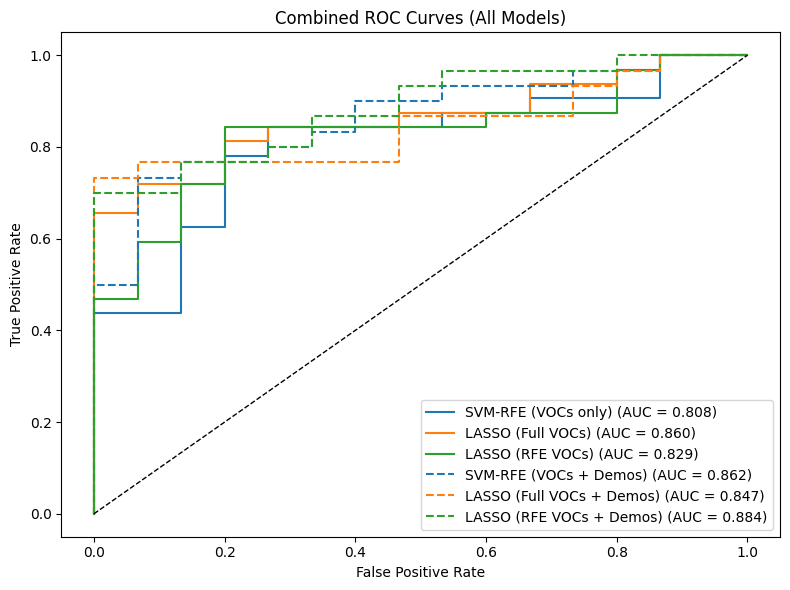


Final ROC-AUCs on Test Set (sorted):
LASSO (RFE VOCs + Demos)            0.884
SVM-RFE (VOCs + Demos)              0.862
LASSO (Full VOCs)                   0.860
LASSO (Full VOCs + Demos)           0.847
LASSO (RFE VOCs)                    0.829
SVM-RFE (VOCs only)                 0.808


In [38]:
plt.figure(figsize=(8, 6))  # calling earlier plot function

# VOC only
auc_svm_voc = plot_model_roc(svm_final_no_demo, x_test_no_demo[svm_rfe_features], y_test_no_demo, "SVM-RFE (VOCs only)", color='tab:blue')
auc_lasso_full_voc = plot_model_roc(lasso_final_no_demo, x_test_no_demo[lasso_full_features_no_demos], y_test_no_demo, "LASSO (Full VOCs)", color='tab:orange')
auc_lasso_rfe_voc = plot_model_roc(lasso_on_rfe_no_demo, x_test_no_demo[overlap_features], y_test_no_demo, "LASSO (RFE VOCs)", color='tab:green')

# VOC + Demos
auc_svm_demo = plot_model_roc(svm_final_demo, x_test_demo[svm_rfe_features_with_demo], y_test_demo, "SVM-RFE (VOCs + Demos)", linestyle='--', color='tab:blue')
auc_lasso_full_demo = plot_model_roc(lasso_final_demo, x_test_demo[lasso_features_demo], y_test_demo, "LASSO (Full VOCs + Demos)", linestyle='--', color='tab:orange')
auc_lasso_rfe_demo = plot_model_roc(lasso_on_rfe_demo, x_test_demo[svm_rfe_vocs_demo], y_test_demo, "LASSO (RFE VOCs + Demos)", linestyle='--', color='tab:green')


plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Combined ROC Curves (All Models)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("output_Combined ROC Curves (All Models).pdf", bbox_inches="tight")
plt.show()

# Print all AUCs
auc_results = [
    {"Model": "SVM-RFE (VOCs only)", "AUC": auc_svm_voc},
    {"Model": "LASSO (Full VOCs)", "AUC": auc_lasso_full_voc},
    {"Model": "LASSO (RFE VOCs)", "AUC": auc_lasso_rfe_voc},
    {"Model": "SVM-RFE (VOCs + Demos)", "AUC": auc_svm_demo},
    {"Model": "LASSO (Full VOCs + Demos)", "AUC": auc_lasso_full_demo},
    {"Model": "LASSO (RFE VOCs + Demos)", "AUC": auc_lasso_rfe_demo}
]

# Sorting
auc_results_sorted = sorted(auc_results, key=lambda x: x["AUC"], reverse=True)

# Print sort
print("\nFinal ROC-AUCs on Test Set (sorted):")
for entry in auc_results_sorted:
    print(f"{entry['Model']:<35} {entry['AUC']:.3f}")  # the 35 is a padding



**Boostrapping**
---

Bootstrapping what was done for more detail than above

SVM-RFE (VOCs only): AUC = 0.809 (95% CI: 0.669–0.924)
LASSO (Full VOCs): AUC = 0.860 (95% CI: 0.745–0.952)
LASSO (RFE VOCs): AUC = 0.828 (95% CI: 0.699–0.937)
SVM-RFE (VOCs + Demos): AUC = 0.863 (95% CI: 0.746–0.955)
LASSO (Full VOCs + Demos): AUC = 0.846 (95% CI: 0.718–0.946)
LASSO (RFE VOCs + Demos): AUC = 0.884 (95% CI: 0.775–0.965)


,Model,Mean AUC,95% CI Lower,95% CI Upper
5,LASSO (RFE VOCs + Demos),0.884140,0.775253,0.965438
3,SVM-RFE (VOCs + Demos),0.863211,0.745690,0.955466
1,LASSO (Full VOCs),0.860331,0.745222,0.952022
4,LASSO (Full VOCs + Demos),0.845949,0.718487,0.946121
2,LASSO (RFE VOCs),0.828106,0.699248,0.936652
0,SVM-RFE (VOCs only),0.809105,0.669355,0.924242


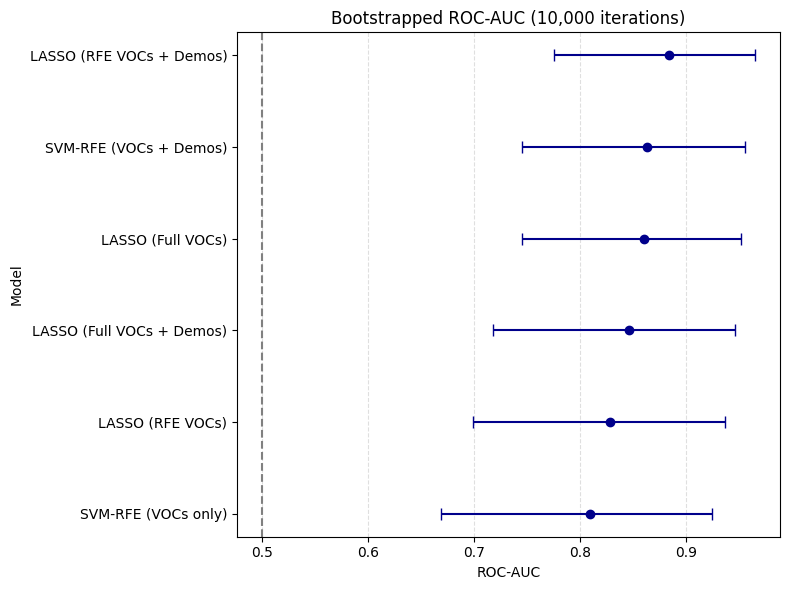

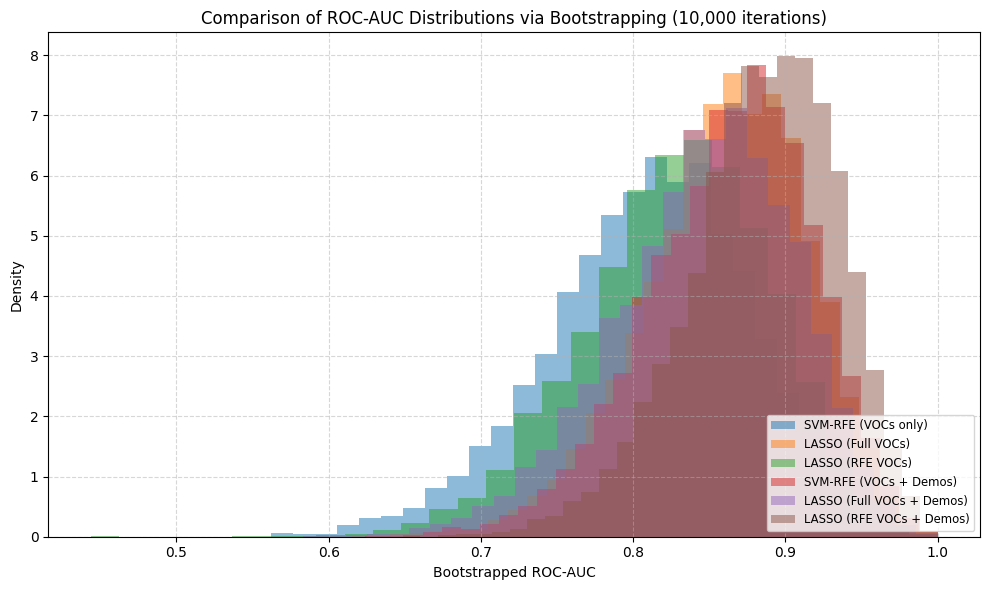

In [39]:
models_info = [
    ("SVM-RFE (VOCs only)", svm_final_no_demo, x_test_no_demo[svm_rfe_features], y_test_no_demo),
    ("LASSO (Full VOCs)", lasso_final_no_demo, x_test_no_demo[lasso_full_features_no_demos], y_test_no_demo),
    ("LASSO (RFE VOCs)", lasso_on_rfe_no_demo, x_test_no_demo[overlap_features], y_test_no_demo),
    ("SVM-RFE (VOCs + Demos)", svm_final_demo, x_test_demo[svm_rfe_features_with_demo], y_test_demo),
    ("LASSO (Full VOCs + Demos)", lasso_final_demo, x_test_demo[lasso_features_demo], y_test_demo),
    ("LASSO (RFE VOCs + Demos)", lasso_on_rfe_demo, x_test_demo[svm_rfe_vocs_demo], y_test_demo)
]

# bootstrap loop
results = []
n_iterations = 10000
rng = np.random.default_rng(42)

for label, model, X, y in models_info:
    scores = []
    for _ in range(n_iterations):
        idx = rng.integers(0, len(X), size=len(X))
        X_sample = X.iloc[idx]
        y_sample = y.iloc[idx]
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_sample)[:, 1]
        else:
            probs = model.decision_function(X_sample)
        auc = roc_auc_score(y_sample, probs)
        scores.append(auc)
    mean_auc = np.mean(scores)
    ci_lower = np.percentile(scores, 2.5)
    ci_upper = np.percentile(scores, 97.5)
    results.append({
        "Model": label,
        "Mean AUC": mean_auc,
        "95% CI Lower": ci_lower,
        "95% CI Upper": ci_upper,
        "Scores": scores  # keep full list for plotting
    })
    print(f"{label}: AUC = {mean_auc:.3f} (95% CI: {ci_lower:.3f}–{ci_upper:.3f})")

# df for summary
summary_df = pd.DataFrame([{k: v for k, v in r.items() if k != "Scores"} for r in results])
summary_df = summary_df.sort_values("Mean AUC", ascending=False)
display(summary_df[["Model", "Mean AUC", "95% CI Lower", "95% CI Upper"]])


# Sort by mean AUC
summary_df_sorted = summary_df.sort_values("Mean AUC", ascending=True)  # for horizontal plot


# Horz. error bar graph
plt.figure(figsize=(8, 6))

plt.errorbar(
    x=summary_df_sorted["Mean AUC"],
    y=summary_df_sorted["Model"],
    xerr=[
        summary_df_sorted["Mean AUC"] - summary_df_sorted["95% CI Lower"],
        summary_df_sorted["95% CI Upper"] - summary_df_sorted["Mean AUC"]
    ],
    fmt='o',
    capsize=4,
    color='darkblue'
)

plt.axvline(x=0.5, color='gray', linestyle='--', label='Chance (AUC = 0.5)')
plt.xlabel("ROC-AUC")
plt.ylabel("Model")
plt.title("Bootstrapped ROC-AUC (10,000 iterations)")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("output_Bootstrapped ROC-AUC HorizErrorBar.pdf", bbox_inches="tight")
plt.show()


# Histogram combo
plt.figure(figsize=(10, 6))
for r in results:
    plt.hist(r["Scores"], bins=30, alpha=0.5, label=r["Model"], density=True)
plt.xlabel("Bootstrapped ROC-AUC")
plt.ylabel("Density")
plt.title("Comparison of ROC-AUC Distributions via Bootstrapping (10,000 iterations)")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("output_Bootstrapped ROC-AUC HistoCombo.pdf", bbox_inches="tight")
plt.show()

**Using Standard logistic regression to obtain CI on best model's features**
--

In [40]:
import statsmodels.api as sm

# Using best model (LASSO (RFE VOCs + Demos))
X = x_test_demo[svm_rfe_vocs_demo].copy()
X = sm.add_constant(X)  # intercept
y = y_test_demo

model = sm.Logit(y, X).fit()

# CI and OR
summary_df = model.summary2().tables[1]
summary_df["Odds Ratio"] = np.exp(summary_df["Coef."])
summary_df["CI Lower"] = np.exp(summary_df["Coef."] - 1.96 * summary_df["Std.Err."])  # 95%
summary_df["CI Upper"] = np.exp(summary_df["Coef."] + 1.96 * summary_df["Std.Err."])  # 95%
summary_df = summary_df[["Coef.", "Std.Err.", "P>|z|", "Odds Ratio", "CI Lower", "CI Upper"]]
summary_df = summary_df.rename(columns={"P>|z|": "p-value"})


print(summary_df)

Optimization terminated successfully.
         Current function value: 0.382779
         Iterations 7
                        Coef.  Std.Err.   p-value  Odds Ratio  CI Lower  \
const                0.979124  0.465536  0.035447    2.662123  1.068946   
000109-52-4_group1  -0.268465  0.536581  0.616846    0.764552  0.267091   
001762-27-2_group1  -1.864285  0.693324  0.007169    0.155007  0.039827   
019549-87-2_group1  -0.382334  0.460974  0.406876    0.682267  0.276417   
063521-76-6_group3   0.068643  0.392198  0.861062    1.071054  0.496554   
1000401-12-0_group1 -0.544632  0.394785  0.167720    0.580055  0.267560   

                     CI Upper  
const                6.629799  
000109-52-4_group1   2.188538  
001762-27-2_group1   0.603282  
019549-87-2_group1   1.684006  
063521-76-6_group3   2.310238  
1000401-12-0_group1  1.257526  


In [41]:
summary_df_pretty = summary_df.copy()


summary_df_pretty = summary_df.rename(columns={
    "Coef.": "Log-Odds",
    "Std.Err.": "Std. Error",
    "p-value": "p",
    "Odds Ratio": "OR",
    "CI Lower": "95% CI Lower",
    "CI Upper": "95% CI Upper"
}).reset_index().rename(columns={"index": "VOC"})

# names to CAS
cas_to_name = {
    "000109-52-4": "Pentanoic acid",
    "001762-27-2": "diethyldimethylplumbane",
    "019549-87-2": "2,4-Dimethyl-1-heptene",
    "063521-76-6": "Tridecanedial",
    "1000401-12-0": "2,5-cyclohexadien-1-one, 2,6-bis(1,1-dimethylethyl)-4-hydroxy-4-methyl-"
}


def format_voc_with_name(voc):
    if voc == "const":
        return "Intercept"
    cas = voc[:-7]  # dropping elution group
    name = cas_to_name.get(cas, "[unknown]")
    return f"{cas}<br><span style='font-size:smaller'>{name}</span>"


# significance stars column
def significance_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""


summary_df_pretty["Significance"] = summary_df_pretty["p"].apply(significance_stars)
summary_df_pretty["VOC"] = summary_df_pretty["VOC"].apply(format_voc_with_name)

# Column order
column_order = [
    "VOC", "Log-Odds", "Std. Error", "p", "Significance",
    "OR", "95% CI Lower", "95% CI Upper"
]
summary_df_pretty = summary_df_pretty[column_order]
summary_df_pretty = summary_df_pretty.sort_values("p", ascending=True)

# Style table
styled = summary_df_pretty.style.set_caption("Logistic Regression Results for Top VOCs") \
    .format({
        "Log-Odds": "{:.3f}",
        "Std. Error": "{:.3f}",
        "p": "{:.3f}",
        "OR": "{:.3f}",
        "95% CI Lower": "{:.3f}",
        "95% CI Upper": "{:.3f}"
    }, na_rep="") \
    .set_table_styles([
        {"selector": "caption", "props": [("caption-side", "top"), ("font-size", "16px"), ("font-weight", "bold")]}
    ]) \
    .hide(axis="index")

styled

# saving
styled.to_html("output_logistic_voc_table.html", escape=True)
summary_df_pretty.to_excel("output_logistic_voc_table.xlsx", index=False)
summary_df_pretty

,VOC,Log-Odds,Std. Error,p,Significance,OR,95% CI Lower,95% CI Upper
2,001762-27-2<br><span style='font-size:smaller'...,-1.864285,0.693324,0.007169,**,0.155007,0.039827,0.603282
0,Intercept,0.979124,0.465536,0.035447,*,2.662123,1.068946,6.629799
5,1000401-12-0<br><span style='font-size:smaller...,-0.544632,0.394785,0.167720,,0.580055,0.267560,1.257526
3,019549-87-2<br><span style='font-size:smaller'...,-0.382334,0.460974,0.406876,,0.682267,0.276417,1.684006
1,000109-52-4<br><span style='font-size:smaller'...,-0.268465,0.536581,0.616846,,0.764552,0.267091,2.188538
4,063521-76-6<br><span style='font-size:smaller'...,0.068643,0.392198,0.861062,,1.071054,0.496554,2.310238


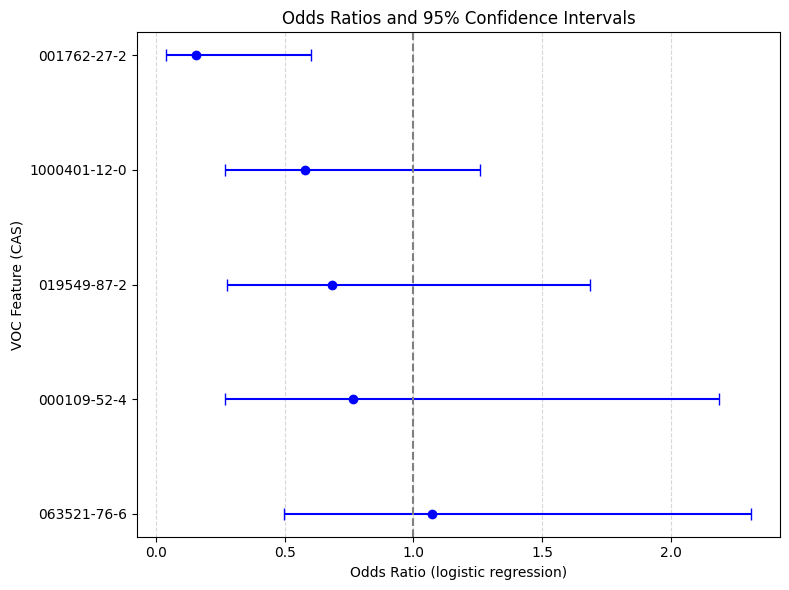

In [42]:
# Filtering and sorting
plot_df = summary_df_pretty[~summary_df_pretty["VOC"].str.contains("Intercept")].copy()  # filtering out intercept
plot_df["VOC_CAS"] = plot_df["VOC"].str.split("<br>").str[0]  # extracting only CAS
plot_df = plot_df.sort_values("p", ascending=False)  # sorts similar to table above


plt.figure(figsize=(8, 6))
plt.errorbar(
    x=plot_df["OR"],
    y=plot_df["VOC_CAS"],  # CAS only
    xerr=[
        plot_df["OR"] - plot_df["95% CI Lower"],
        plot_df["95% CI Upper"] - plot_df["OR"]
    ],
    fmt='o',
    capsize=4,
    color='b'
)

plt.axvline(x=1, color='gray', linestyle='--', label='OR = 1 (no effect)')
plt.xlabel("Odds Ratio (logistic regression)")
plt.ylabel("VOC Feature (CAS)")
plt.title("Odds Ratios and 95% Confidence Intervals")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("output_odds_ratios_plot.pdf", bbox_inches="tight")
plt.show()

In [43]:
# Passing to next notebook
import joblib

# model
joblib.dump(lasso_on_rfe_no_demo, "lasso_on_rfe_no_demo.pkl")

# test data
joblib.dump(x_test_no_demo, "x_test_no_demo.pkl")
joblib.dump(y_test_no_demo, "y_test_no_demo.pkl")

# feature names if needed
joblib.dump(overlap_features, "overlap_features.pkl")

['overlap_features.pkl']